# Experiment 7: SVM + Fairlearn ExponentiatedGradient (Equal Opportunity) - Retrain + Validate

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Step 0: Setup Environment
!pip install fairlearn shap scikit-learn aif360 pandas matplotlib seaborn joblib openpyxl --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 24.5 MB/s eta 0:00:00


In [3]:
# Step 1: Imports
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt

from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric

pip install 'aif360[inFairness]'


In [4]:
# Step 2: Load and Preprocess Training Dataset
df = pd.read_csv('/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv')

selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna()

df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col])

df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])

In [5]:

# Step 3: Create AIF360 Dataset
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

X = aif_data.features
y = aif_data.labels.ravel()
prot_attr = aif_data.protected_attributes.ravel()

In [6]:


# Step 4: Train SVM with Fairlearn EqualizedOdds Constraint
base_estimator = SVC(kernel='rbf', C=1.0, probability=True, random_state=42, cache_size=500)
constraint = EqualizedOdds()
mitigator = ExponentiatedGradient(base_estimator, constraints=constraint, max_iter=20)

print('Training model with Fairlearn constraints...')
mitigator.fit(X, y, sensitive_features=prot_attr)

# Save model
MODEL_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/svm_fairlearn_v2.pkl'
joblib.dump(mitigator, MODEL_PATH)
print(f'Model retrained and saved to: {MODEL_PATH}')

Training model with Fairlearn constraints...
Model retrained and saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/trained models/svm_fairlearn_v2.pkl


In [7]:
# Step 5: Preprocess External Test Dataset
def preprocess_testdata(df):
    df = df.copy()
    processed = pd.DataFrame()

    scaler = StandardScaler()
    processed['annual_inc'] = scaler.fit_transform(df[['annual_inc']].fillna(df['annual_inc'].median())).ravel()

    le = LabelEncoder()
    processed['term'] = le.fit_transform(df['term'].astype(str))

    le = LabelEncoder()
    processed['grade'] = le.fit_transform(df['grade'].astype(str))

    le = LabelEncoder()
    processed['home_ownership'] = le.fit_transform(df['home_ownership'].astype(str))

    le = LabelEncoder()
    processed['purpose'] = le.fit_transform(df['purpose'].astype(str))

    le = LabelEncoder()
    processed['zip_code'] = le.fit_transform(df['zip_code'].astype(str))

    status_map = {
        'Fully Paid': 1,
        'Current': 1,
        'Charged Off': 0,
        'Default': 0,
        'Late (31-120 days)': 0,
        'Late (16-30 days)': 0,
        'In Grace Period': 0
    }
    df['loan_status_mapped'] = df['loan_status'].map(status_map).fillna(0).astype(int)
    processed['loan_status'] = df['loan_status_mapped']

    return processed.dropna()


In [8]:
# Step 6: Validation Function
def validate_on_testdata(df_processed, model):
    privileged_groups = [{'zip_code': 1}]
    unprivileged_groups = [{'zip_code': 0}]

    aif_data = StandardDataset(df_processed,
                               label_name='loan_status',
                               favorable_classes=[1],
                               protected_attribute_names=['zip_code'],
                               privileged_classes=[[1]])
    X = aif_data.features
    y = aif_data.labels.ravel()

    y_pred = model.predict(X)
    try:
        y_prob = model.predict_proba(X)[:, 1]
    except Exception:
        y_prob = y_pred.astype(float)

    print('\nPERFORMANCE METRICS')
    print("Accuracy:", accuracy_score(y, y_pred))
    print("Precision:", precision_score(y, y_pred))
    print("Recall:", recall_score(y, y_pred))
    print("F1 Score:", f1_score(y, y_pred))
    try:
        print("AUC-ROC:", roc_auc_score(y, y_prob))
    except Exception:
        print("AUC-ROC: N/A")

    print('\nClassification Report:')
    print(classification_report(y, y_pred, zero_division=0))

    print('\nFAIRNESS METRICS')
    pred_dataset = aif_data.copy()
    pred_dataset.labels = y_pred.reshape(-1, 1)
    metric = ClassificationMetric(aif_data, pred_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)
    print("Statistical Parity Difference:", metric.statistical_parity_difference())
    print("Disparate Impact:", metric.disparate_impact())
    print("Equal Opportunity Difference:", metric.equal_opportunity_difference())
    print("Average Odds Difference:", metric.average_odds_difference())
    print("Bias Amplification:", metric.between_group_generalized_entropy_index())
    print("Theil Index:", metric.theil_index())

    print('\nEXPLAINABILITY METRICS')
    X_df = pd.DataFrame(X, columns=aif_data.feature_names)

    # Sample background and test instances for KernelExplainer
    background_size = min(100, X.shape[0])
    background_idx = np.random.choice(X.shape[0], background_size, replace=False)
    X_background = X[background_idx]

    explain_size = min(200, X.shape[0])
    explain_idx = np.random.choice(X.shape[0], explain_size, replace=False)
    X_explain = X[explain_idx]
    X_explain_df = pd.DataFrame(X_explain, columns=aif_data.feature_names)

    explainer = shap.KernelExplainer(model.predict, X_background)
    shap_values = explainer.shap_values(X_explain_df, nsamples=50)

    shap.summary_plot(shap_values, X_explain_df, show=False)
    plt.title('SHAP Summary - Experiment 7 (SVM + Fairlearn)')
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/shap_exp7_testdata.png', dpi=150)
    plt.show()

    return {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred),
        'AUC': roc_auc_score(y, y_prob) if len(np.unique(y_prob)) > 1 else None,
        'SPD': metric.statistical_parity_difference(),
        'DI': metric.disparate_impact(),
        'EOD': metric.equal_opportunity_difference(),
        'AOD': metric.average_odds_difference(),
        'BiasAmp': metric.between_group_generalized_entropy_index(),
        'Theil': metric.theil_index()
    }



PERFORMANCE METRICS
Accuracy: 0.8122375524895021
Precision: 0.8122375524895021
Recall: 1.0
F1 Score: 0.896391923204237
AUC-ROC: 0.5

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       939
         1.0       0.81      1.00      0.90      4062

    accuracy                           0.81      5001
   macro avg       0.41      0.50      0.45      5001
weighted avg       0.66      0.81      0.73      5001


FAIRNESS METRICS
Statistical Parity Difference: 0.0
Disparate Impact: 1.0
Equal Opportunity Difference: nan
Average Odds Difference: nan
Bias Amplification: 277.3333333333334
Theil Index: 0.047075291905912905

EXPLAINABILITY METRICS


  0%|          | 0/200 [00:00<?, ?it/s]

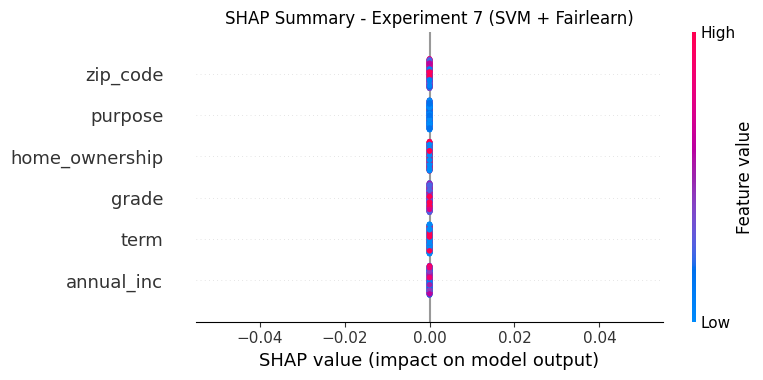

In [9]:

# Step 7: Run Validation
RESULTS_DIR = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results'
TESTDATA_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation dataset/TestData set.xlsx'

test_df = pd.read_excel(TESTDATA_PATH)
test_processed = preprocess_testdata(test_df)
results = validate_on_testdata(test_processed, mitigator)


In [10]:


# Step 8: Save Results
results_df = pd.DataFrame([results])
output_path = f'{RESULTS_DIR}/experiment7_validation_results_testdata.csv'
results_df.to_csv(output_path, index=False)
print(f'\nResults saved to: {output_path}')


Results saved to: /content/drive/MyDrive/Research_Thesis_Implementation/Validation files & results/Validation Results/experiment7_validation_results_testdata.csv
